In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yasa
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from scipy.integrate import simpson
from scipy.signal import find_peaks
mne.set_log_level("error")
mne.viz.set_browser_backend('qt')
mne.set_config('MNE_BROWSER_THEME', 'dark')
face_electrodes = ['E238', 'E234', 'E230', 'E226', 'E225', 'E241', 'E244', 'E248', 'E252', 'E253', 'E242', 'E243', 'E245', 'E246', 'E249', 'E247', 'E250', 'E251', 'E255', 'E254', 
                   'E73', 'E54', 'E37', 'E32', 'E31', 'E18', 'E25', 'E61', 'E46', 'E67', 'E68', 'E239', 'E240', 'E235', 'E231', 'E236', 'E237', 'E232', 'E227', 'E210', 'E219', 'E220', 
                   'E1', 'E10', 'E218', 'E228', 'E233']
neck_electrodes = ['E145', 'E146', 'E147', 'E156', 'E165', 'E174', 'E166', 'E157', 'E148', 'E137', 'E136', 'E135', 'E134', 'E133']
sub_to_hypno_path = {'31': 'HC_V1/EL3006', '26': 'HC_V1/RD43', '9': 'HK5'}

## Full File

In [2]:
sub = "26"
path = f"D:/Shaked_data/ISO/{sub}_filtered.fif"
raw = mne.io.read_raw(path)
raw.pick(["E81", "E45", "E44"])
raw.plot()

In [129]:
raw.save(f"D:/Shaked_data/ISO/{sub}_filtered_3_channels.fif")

In [5]:
sub = "26"
path = f"D:/Shaked_data/EGI_cleaning/input_files/{sub}.mff"
raw = mne.io.read_raw(path)

In [3]:
curr_channels = [x for x in raw.ch_names if x not in face_electrodes and x not in neck_electrodes]
curr_channels = [x for x in curr_channels if x.startswith("E") or x == "VREF"]
print(f"{len(curr_channels)} channels")
_ = raw.pick(curr_channels)

198 channels


In [ ]:
_ = raw.resample(250)
raw.load_data()
# TODO: theirs was 0.27-39.25
raw.filter(l_freq=0.1, h_freq=40, phase='zero-double')
_ = raw.set_eeg_reference('average')

In [58]:
hypnogram_path = f"D:/Shaked_data/EGI_cleaning/output_files/{sub_to_hypno_path[sub]}.txt"
hypno = np.loadtxt(hypnogram_path, dtype=int)

expected_epochs = int(raw.times[-1])
diff_mins = np.abs((expected_epochs - len(hypno)) / 60)
if len(hypno) > expected_epochs:
    hypno = hypno[:expected_epochs]
    print(f"hypno is longer by {diff_mins:.2f} minutes")

hypno is longer by 1.53 minutes


In [ ]:
stage_map = {-1: 'UNKNOWN', 0: 'Wake', 1: 'NREM1', 2: 'NREM2', 3: 'NREM3', 4: 'REM'}

# Collapse into annotation blocks
onsets, durations, descriptions = [], [], []
start, current = 0, hypno[0]
for i in range(1, len(hypno)):
    if hypno[i] != current:
        onsets.append(start)
        durations.append(i - start)
        descriptions.append(stage_map.get(current, 'UNKNOWN'))
        start, current = i, hypno[i]

onsets.append(start)
durations.append(len(hypno) - start)
descriptions.append(stage_map.get(current, 'UNKNOWN'))

sleep_annot = mne.Annotations(onsets, durations, descriptions, raw.annotations.orig_time)

# set previously marked annotations 
annot_path = f"D:/Shaked_data/EGI_cleaning/output_files/{sub}_output/CleaningPipe/annotations.txt"
annotations = mne.read_annotations(annot_path)
_ = raw.set_annotations(annotations + sleep_annot)

In [66]:
raw.plot(theme='dark', duration=30, bad_color='red', n_channels=len(raw.ch_names) // 5) #, scalings=dict(eeg=5e-5, eog=4e-4, seeg=1e-4), 

In [67]:
raw.save(f"D:/Shaked_data/ISO/{sub}_filtered.fif")

## N2 Chunk 

#### creation

In [69]:
raw.pick(["VREF", "E9", "E186", "E132", "E81", "E45", "E44", "E185", "E197", "E198", "E8", "E17", "E7", "E16", "E5"])
raw.plot(theme='dark', duration=30, bad_color='red', n_channels=len(raw.ch_names))

In [70]:
raw_cropped = raw.copy().crop(7418, 8163)

In [78]:
raw_cropped.plot(duration=30)

In [ ]:
raw_cropped.save(f"D:/Shaked_data/ISO/{sub}_cropped.fif")

#### loading

In [3]:
sub = "26"
path = f"D:/Shaked_data/ISO/{sub}_cropped.fif"
raw_cropped = mne.io.read_raw(path)
raw_cropped.plot(duration=30)

In [18]:
print(f"High-pass filter: {raw_cropped.info['highpass']} Hz")
print(f"Low-pass filter: {raw_cropped.info['lowpass']} Hz")

High-pass filter: 0.10000000149011612 Hz
Low-pass filter: 40.0 Hz


In [21]:
# Just timings 
print(raw_cropped.times[0:5],  raw_cropped.times[-1])
print((-raw_cropped.first_samp+ raw_cropped.last_samp)/raw_cropped.info['sfreq'])
print(raw_cropped.info['meas_date'])
print(raw_cropped.info['sfreq'])
print(raw_cropped.times + (raw_cropped.first_samp / raw_cropped.info['sfreq']))
print(raw_cropped.first_samp / raw_cropped.info['sfreq'])

print("\nfull raw")
print("***********")
print(raw.times[0],  raw.times[-1])
print(raw.first_samp, raw.last_samp)
print(raw.info['meas_date'])
print(raw.info['meas_date'] == raw_cropped.info['meas_date'])
print(raw.last_samp / raw.info['sfreq'])
print((-raw.first_samp+ raw.last_samp)/raw.info['sfreq'])
print(raw.first_samp / raw.info['sfreq'])


[0.    0.004 0.008 0.012 0.016] 745.0
745.0
2022-12-13 05:33:00.613226+00:00
250.0
[7418.    7418.004 7418.008 ... 8162.992 8162.996 8163.   ]
7418.0

full raw
***********
0.0 22661.616
0 22661616
2022-12-13 05:33:00.613226+00:00
True
22661.616
22661.616
0.0


### Spindle Detection (Fig 1A)

In [4]:
low_freq = 13
high_freq = 16
target_channel = 'VREF'

In [5]:
# hypno = yasa.mne_to_hypno(raw, mapping=stage_map)
spindles = yasa.spindles_detect(raw_cropped, freq_sp=(low_freq, high_freq))
df_spindles = spindles.summary()
target_df = df_spindles[df_spindles['Channel'] == target_channel]

annotations = mne.Annotations(target_df['Start'].values, target_df['Duration'].values, ['Spindle_' + target_channel] * len(target_df))
target_raw = raw_cropped.copy().pick_channels([target_channel])
_ = target_raw.set_annotations(annotations)

In [6]:
target_raw.plot(duration=30)

In [7]:
start_time = 70
duration = 40
time_scale = 1  # length of time marker in seconds
voltage_scale = 30  # in µV

sfreq = target_raw.info['sfreq']
start_sample = int(start_time * sfreq)
stop_sample = int((start_time + duration) * sfreq)

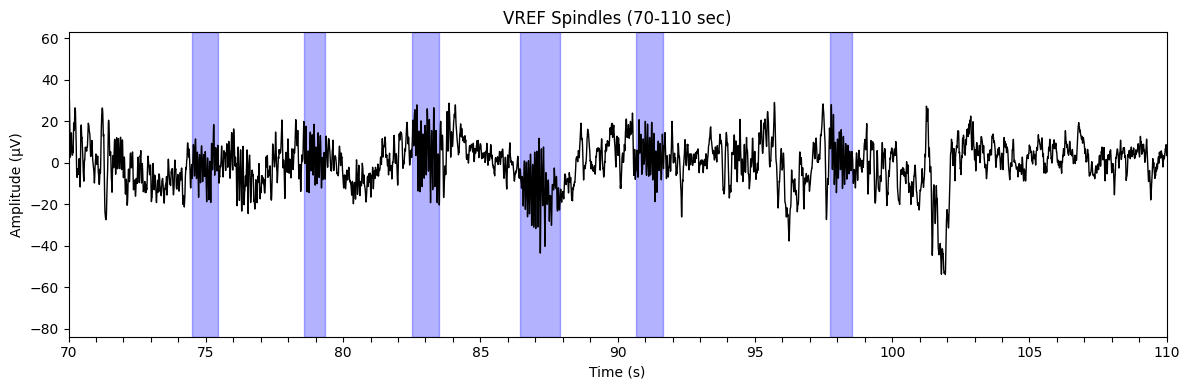

In [8]:
data, times = target_raw.get_data(start=start_sample, stop=stop_sample, return_times=True)
data = data[0] * 1e6  # convert from V to µV
spindle_mask = (target_df['Start'] >= start_time) & (target_df['Start'] <= start_time + duration)
curr_spindles = target_df[spindle_mask]
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(times, data, color='black', lw=1, alpha=1)

for _, row in curr_spindles.iterrows():
    ax.axvspan(row['Start'], row['Start'] + row['Duration'], color='blue', alpha=0.3)

ax.set_xlim(times[0], times[-1])
ax.set_ylim(data.min() - voltage_scale, data.max() + voltage_scale)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (µV)')
ax.set_title(f'{target_channel} Spindles ({start_time}-{start_time + duration} sec)')

xticks = np.arange(start_time, start_time + duration + 1)
ax.set_xticks(xticks)
xtick_labels = [str(tick) if tick % 5 == 0 else '' for tick in xticks]
ax.set_xticklabels(xtick_labels)

plt.tight_layout()
plt.show()

### Sigma Power Time Course (Fig 1B)

In [9]:
target_raw.load_data()
spindle_bandpass = target_raw.copy().filter(l_freq=low_freq, h_freq=high_freq)

In [20]:
spindle_bandpass.plot(duration=30)

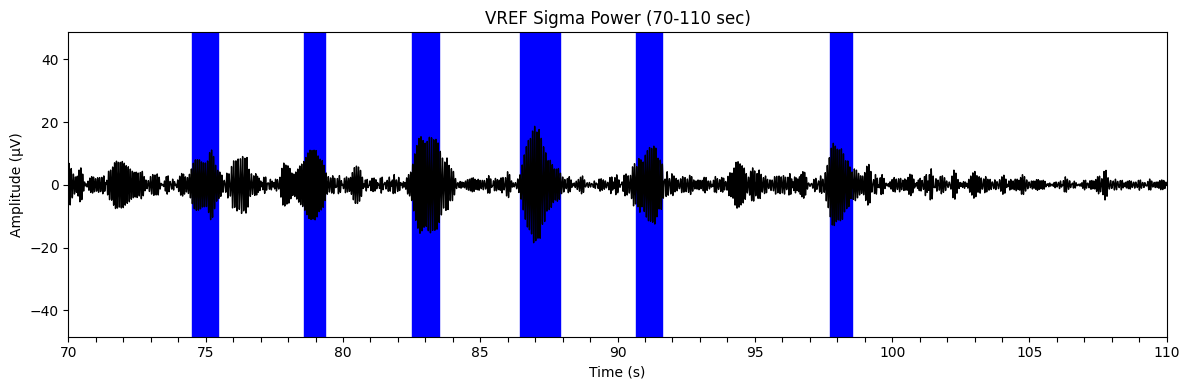

In [11]:
data, times = spindle_bandpass.get_data(start=start_sample, stop=stop_sample, return_times=True)
data = data[0] * 1e6  # convert from V to µV

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(times, data, color='black', lw=1)
for _, row in curr_spindles.iterrows():
    ax.axvspan(row['Start'], row['Start'] + row['Duration'], color='blue')

ax.set_xlim(times[0], times[-1])
ax.set_ylim(data.min() - voltage_scale, data.max() + voltage_scale)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (µV)')
ax.set_title(f'{target_channel} Sigma Power ({start_time}-{start_time + duration} sec)')

xticks = np.arange(start_time, start_time + duration + 1)
ax.set_xticks(xticks)
xtick_labels = [str(tick) if tick % 5 == 0 else '' for tick in xticks]
ax.set_xticklabels(xtick_labels)

plt.tight_layout()
plt.show()

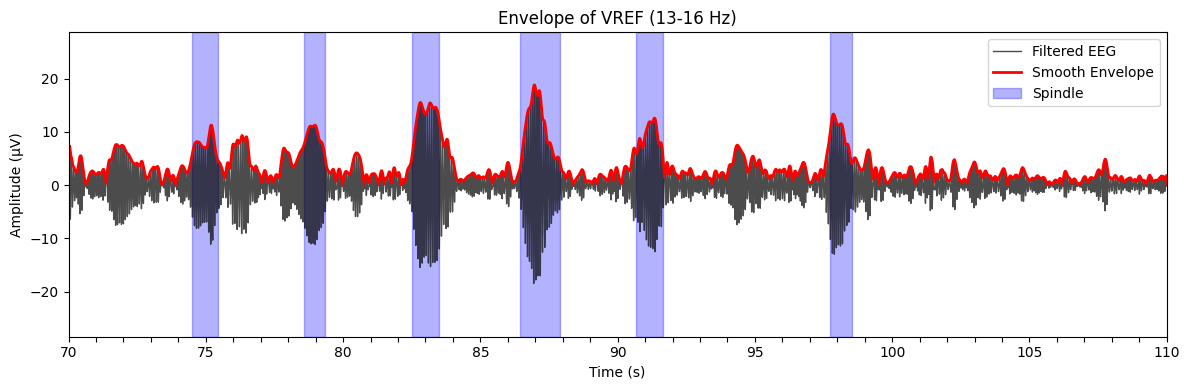

In [12]:
data, times = spindle_bandpass.get_data(start=start_sample, stop=stop_sample, return_times=True)
data = data[0] * 1e6  # convert from V to µV

analytic_signal = hilbert(data)
amplitude_envelope = np.abs(analytic_signal)
# smooth_envelope = gaussian_filter1d(amplitude_envelope, sigma=100)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(times, data, color='black', lw=1, label="Filtered EEG", alpha=0.7)
ax.plot(times, amplitude_envelope, label="Smooth Envelope", color="red", linewidth=2)
for i, (_, row) in enumerate(curr_spindles.iterrows()):
    label = "Spindle" if i == 0 else None  # only label the first
    ax.axvspan(row['Start'], row['Start'] + row['Duration'], color='blue', alpha=0.3, label=label)

ax.set_xlabel("Time (s)")
ax.set_ylabel('Amplitude (µV)')
ax.set_title(f"Envelope of {target_channel} ({low_freq}-{high_freq} Hz)")
ax.set_xlim(times[0], times[-1])
ax.set_ylim(data.min() - 10, data.max() + 10)
xticks = np.arange(start_time, start_time + duration + 1)
ax.set_xticks(xticks)
xtick_labels = [str(tick) if tick % 5 == 0 else '' for tick in xticks]
ax.set_xticklabels(xtick_labels)
plt.legend()
plt.tight_layout()
plt.show()

### Wavelets

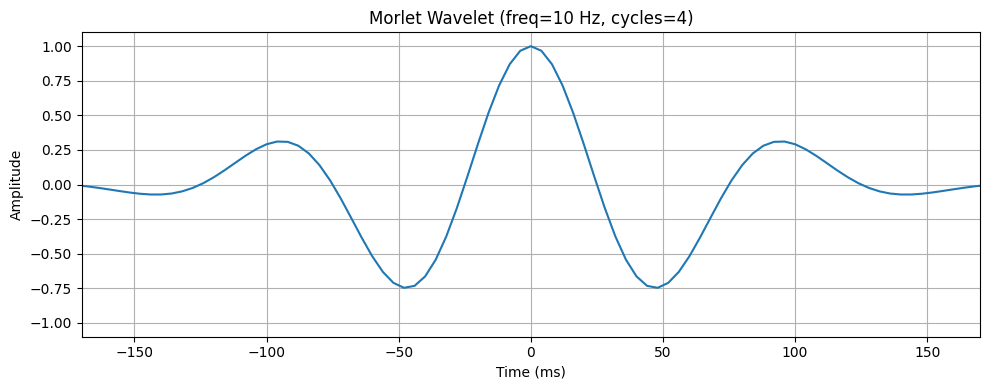

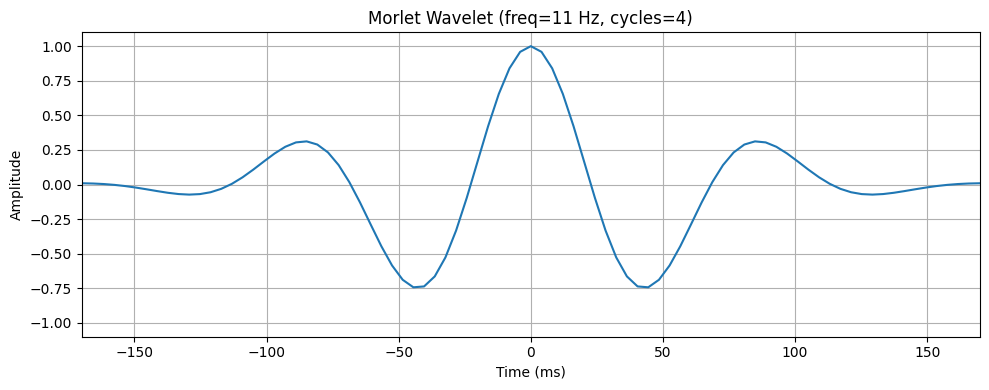

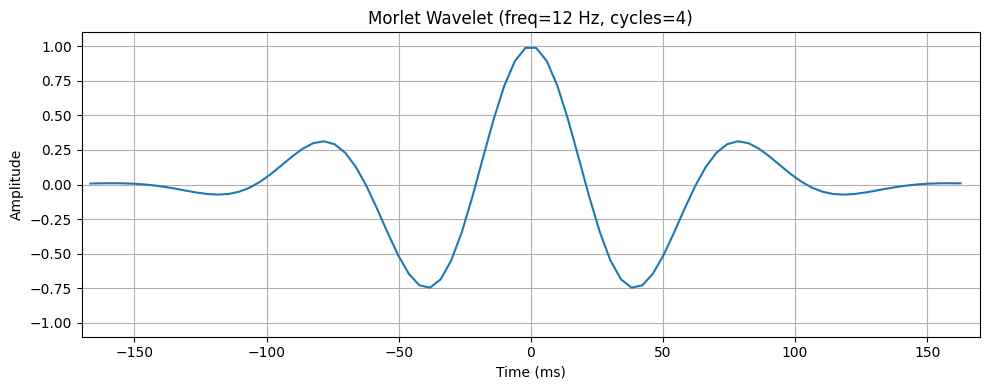

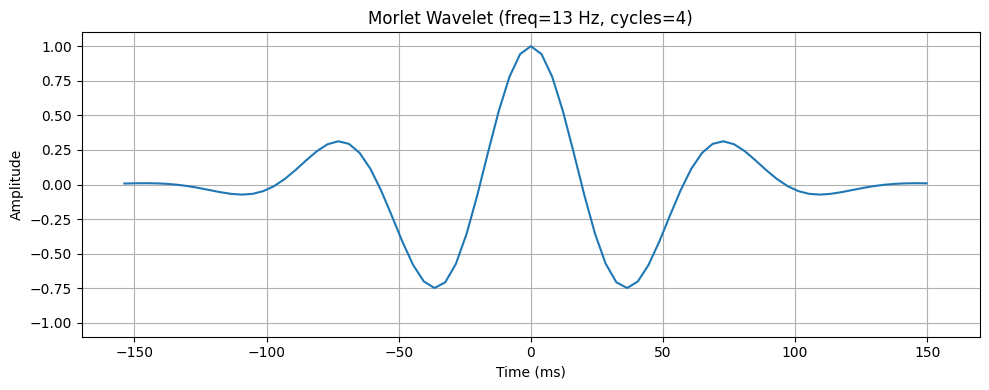

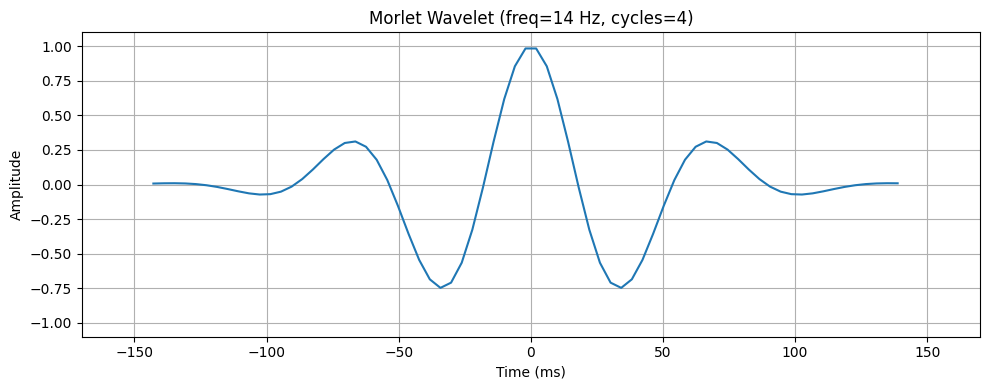

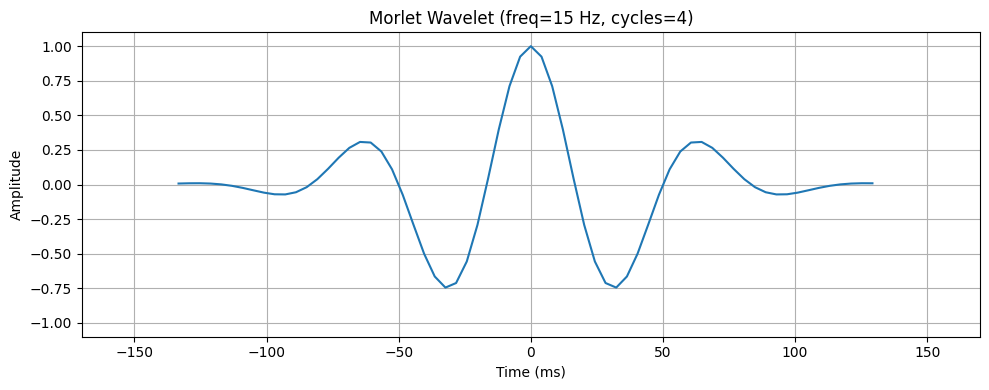

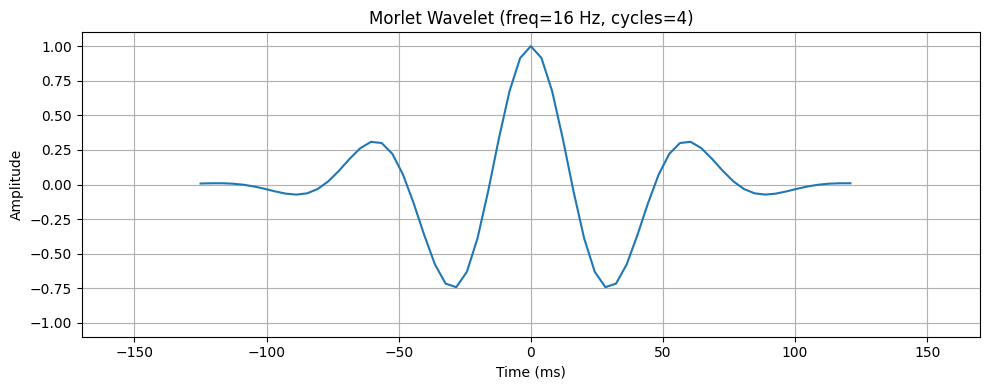

In [73]:
# for cycles in [1, 2, 3, 4]:
for freq in [10, 11, 12, 13, 14, 15, 16]:
# for norm in [True, False]:
    # freq = 12.2
    cycles = 4
    sampling_rate = 250
    norm = False

    duration = cycles / freq  # seconds
    t = np.linspace(-duration/2, duration/2, int(sampling_rate * duration), endpoint=False) # in seconds

    sine_wave = np.exp(2j * np.pi * freq * t)  # complex sine
    gaussian_window = np.exp(-t**2 / (2 * (cycles / (2 * np.pi * freq))**2))  # Gaussian envelope
    morlet_wavelet = sine_wave * gaussian_window
    if norm:
        morlet_wavelet /= np.sqrt(np.sum(np.abs(morlet_wavelet)**2))

    plt.figure(figsize=(10, 4))
    plt.plot(t * 1000, morlet_wavelet.real)
    plt.title(f'Morlet Wavelet (freq={freq} Hz, cycles={cycles})') #, norm={norm})')
    plt.xlabel('Time (ms)')
    plt.xlim((-170, 170))
    plt.ylabel('Amplitude')
    plt.ylim((-1.1, 1.1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
data, times = raw_cropped.get_data(picks='eeg', return_times=True)  # shape: (n_channels, n_times)
freqs = np.arange(10, 16.1, 0.2)
n_channels = len(raw_cropped.info['ch_names'])
sigma_power_all = np.zeros((len(freqs), n_channels, times.shape[0]))
cycles = 4

for i, wavelet_freq in enumerate(freqs):
    # Create Morlet wavelet
    duration = cycles / wavelet_freq
    t_wavelet = np.linspace(-duration / 2, duration / 2, int(raw_cropped.info['sfreq'] * duration), endpoint=False)
    sine_wave = np.exp(2j * np.pi * wavelet_freq * t_wavelet)
    gaussian_window = np.exp(-t_wavelet**2 / (2 * (cycles / (2 * np.pi * wavelet_freq))**2))
    morlet_wavelet = sine_wave * gaussian_window

    # Normalize wavelet to unit energy (optional but common)
    # morlet_wavelet /= np.sqrt(np.sum(np.abs(morlet_wavelet)**2))

    # Apply to each channel
    for ch in range(n_channels):
        convolved = np.convolve(data[ch], morlet_wavelet, mode='same')
        sigma_power_all[i][ch] = np.abs(convolved)  # Magnitude gives power at each time point

In [ ]:
channel_names = raw_cropped.info['ch_names']
df_sigma_power = pd.DataFrame(sigma_power.T, columns=channel_names)
df_sigma_power.insert(0, 'Time (s)', times)

In [132]:
sigma_avg_freq.shape

(15, 186251)

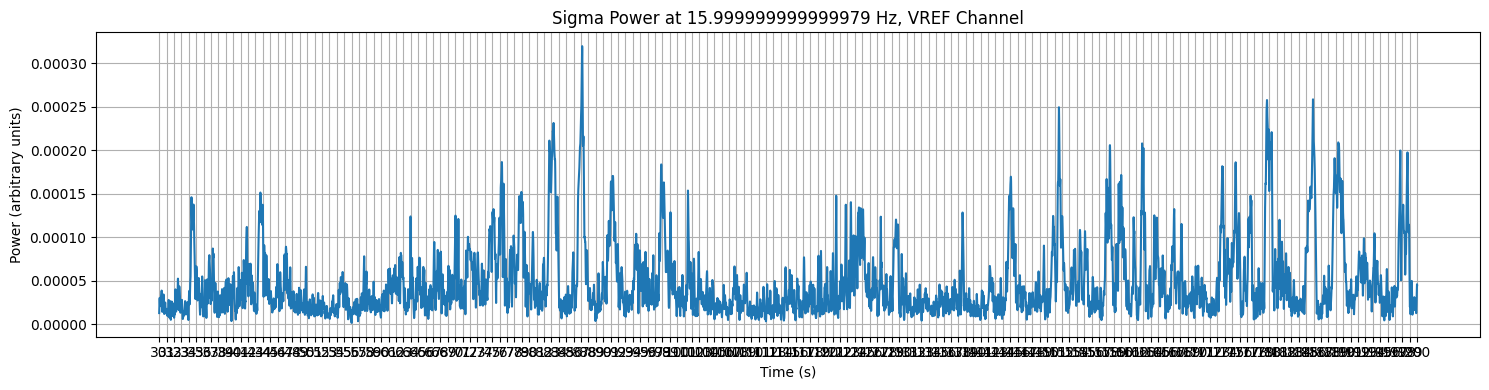

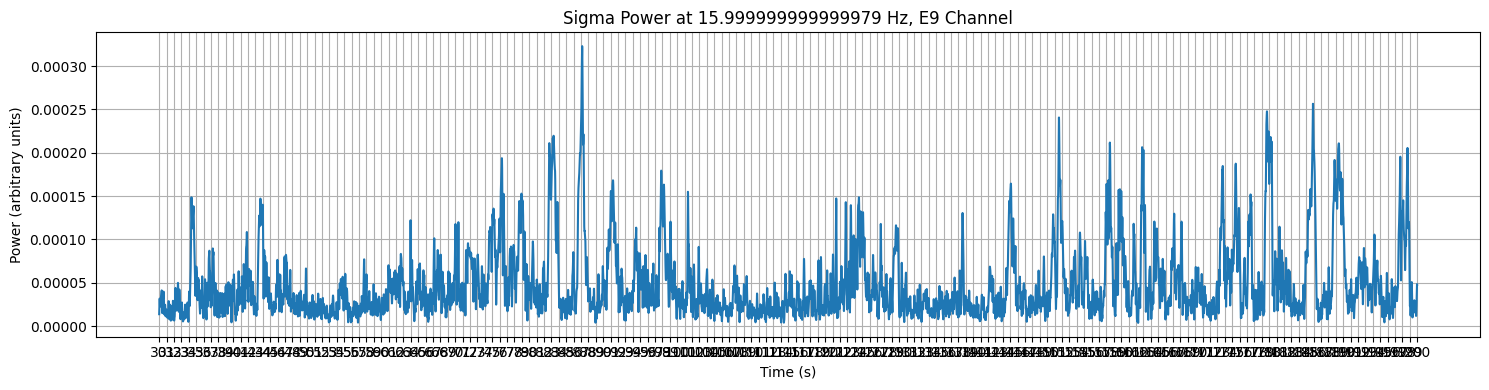

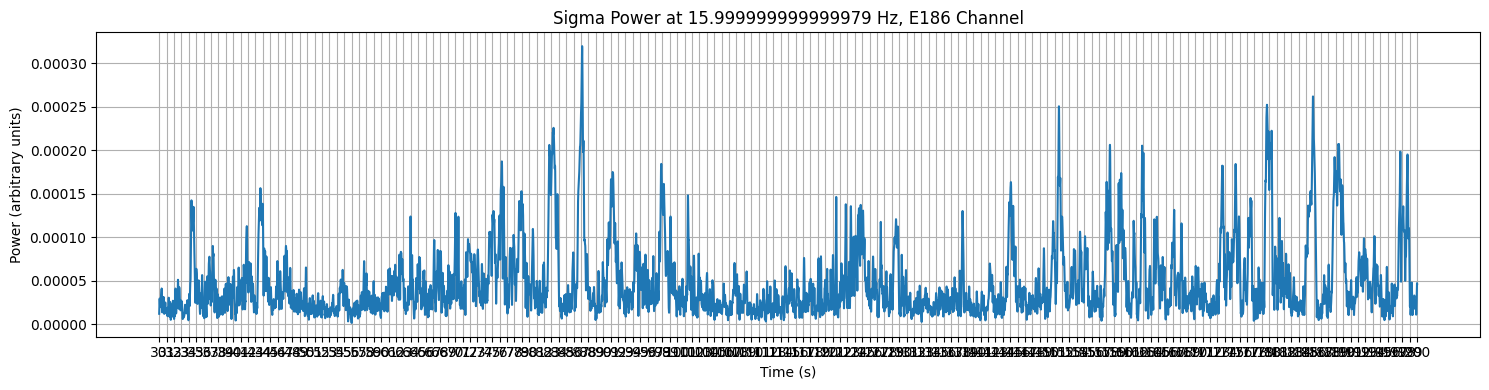

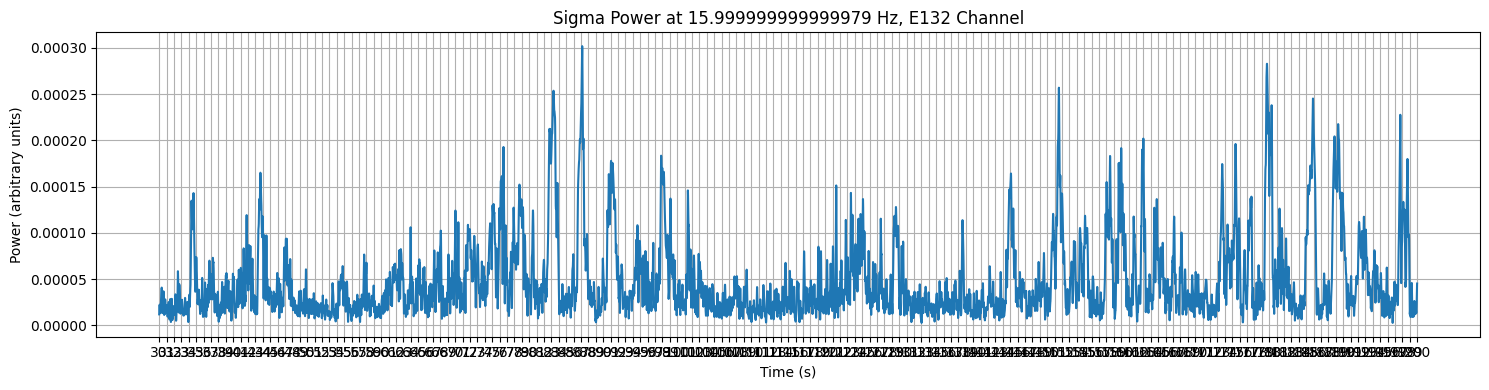

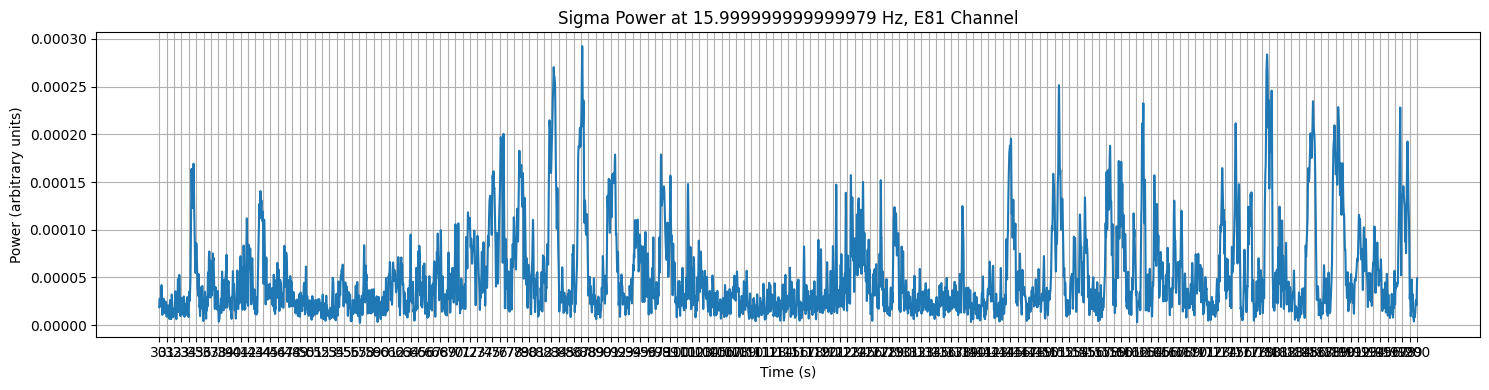

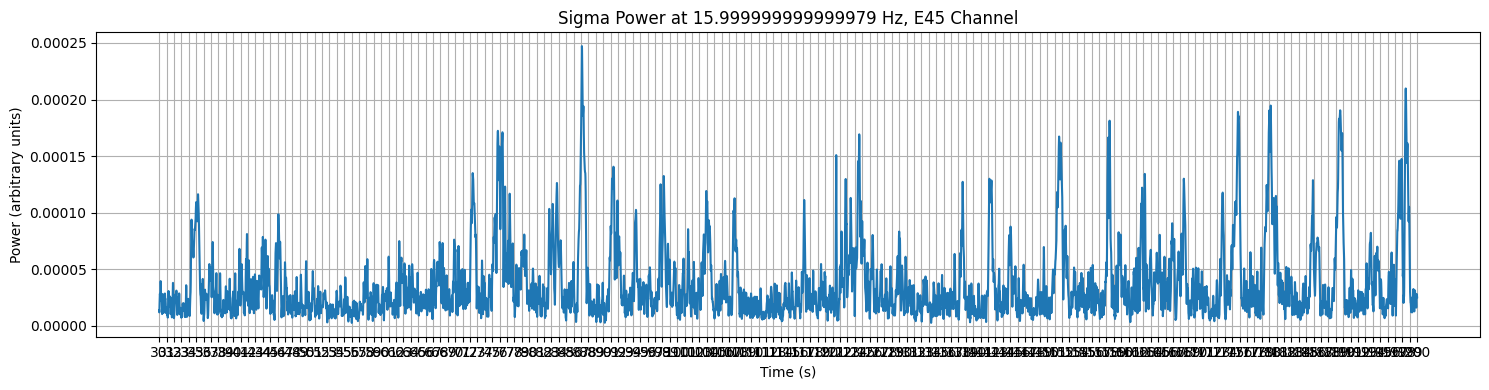

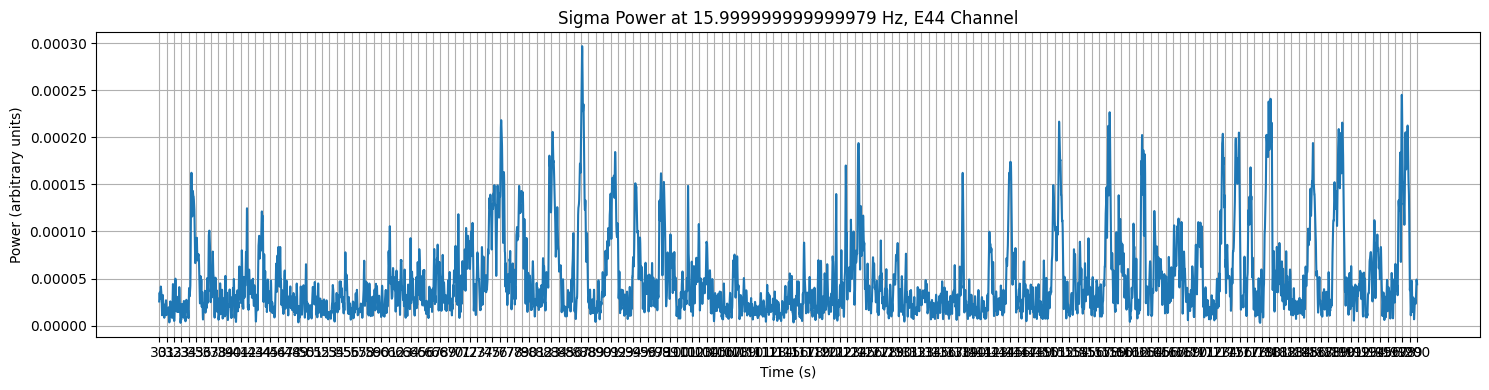

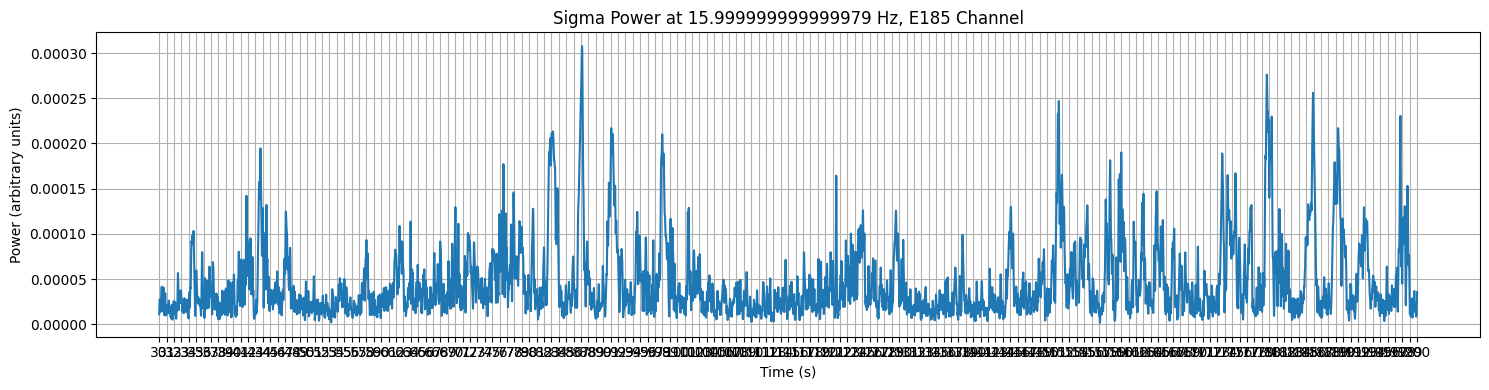

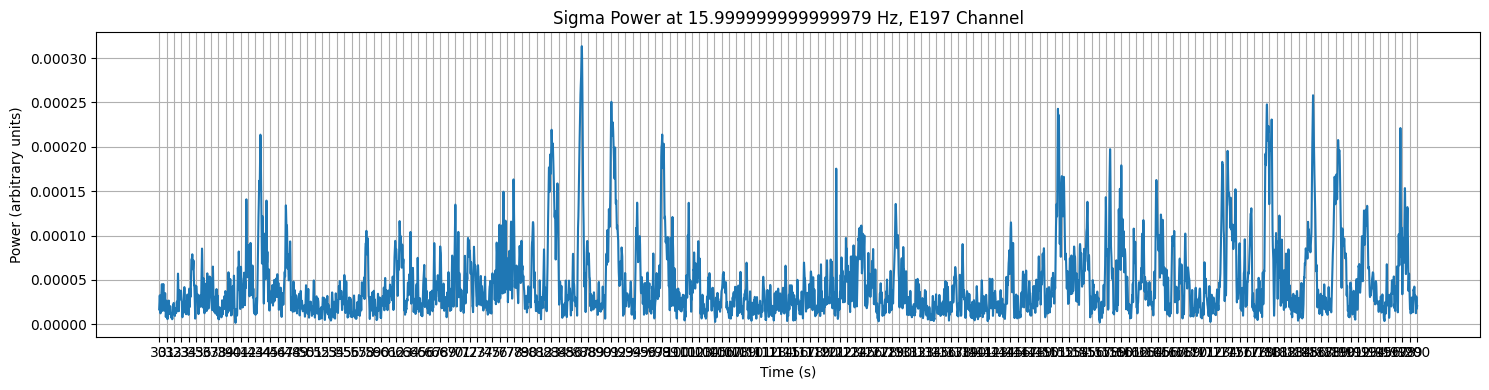

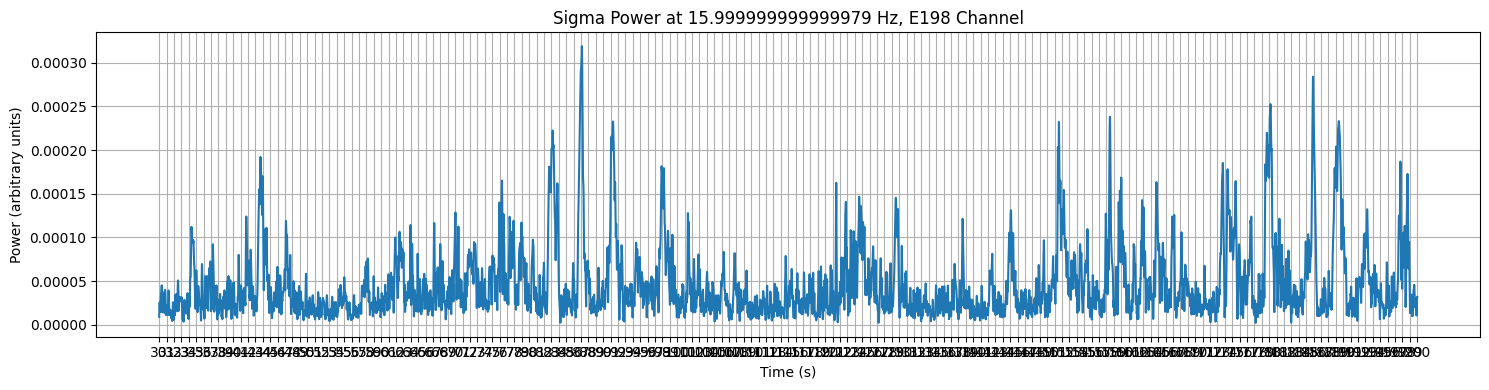

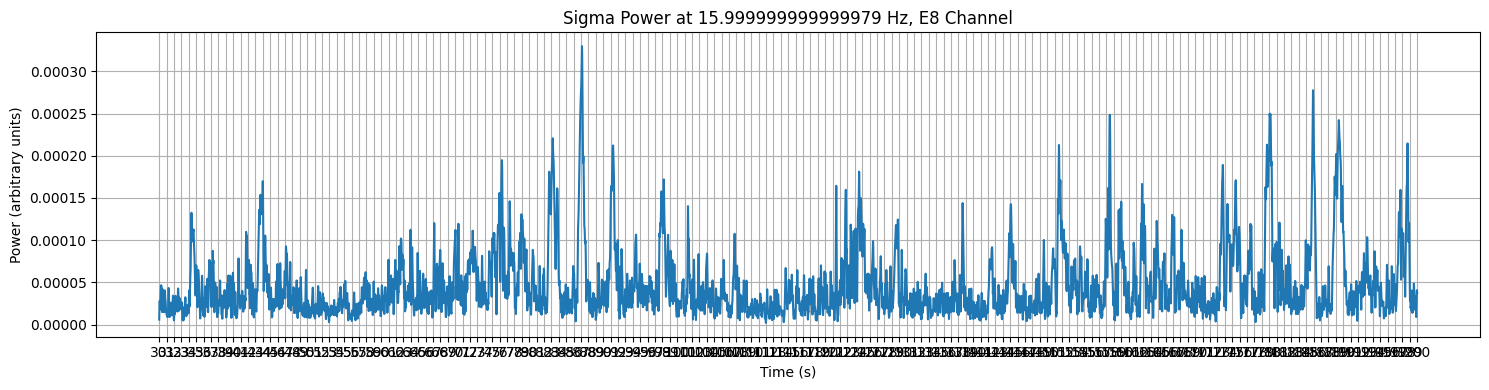

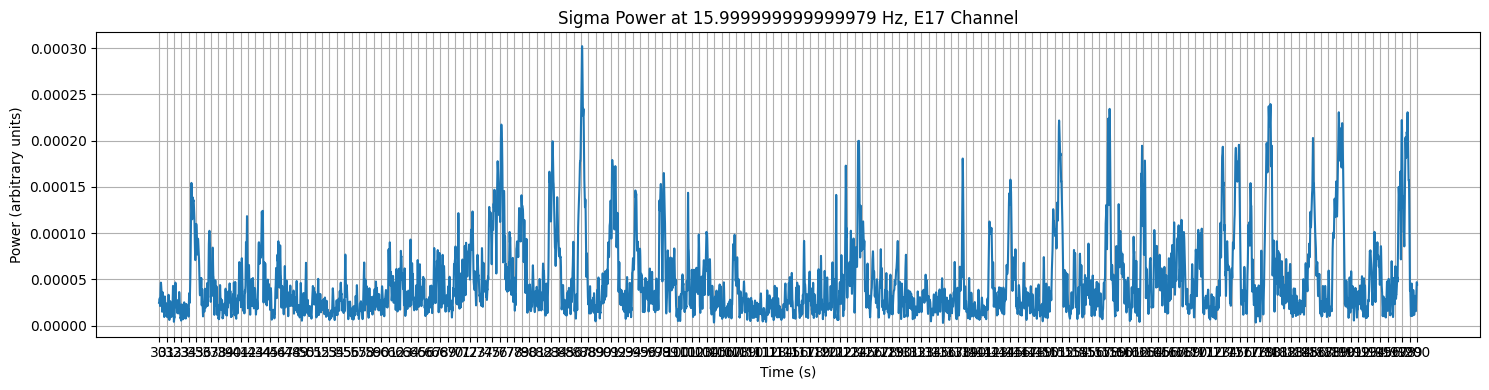

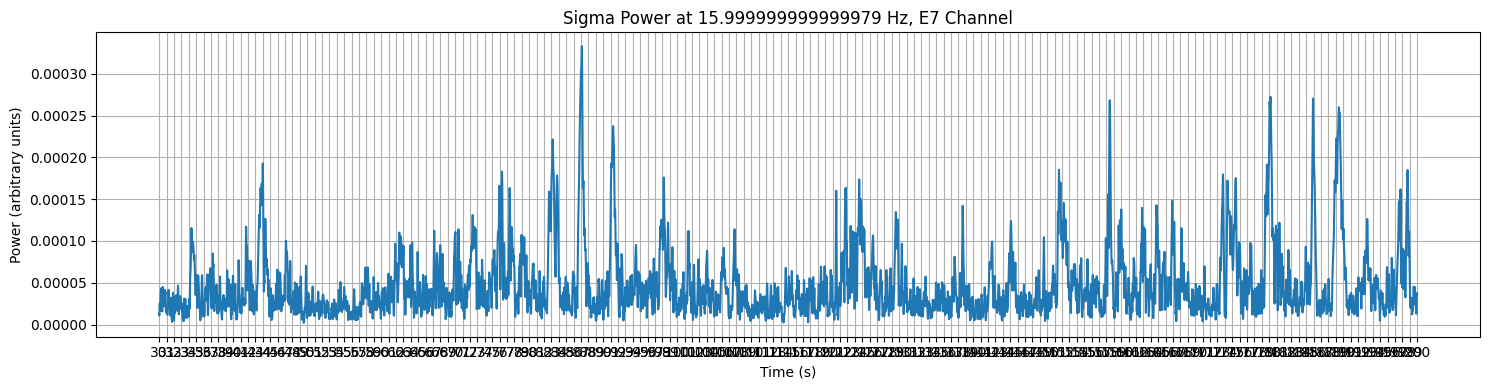

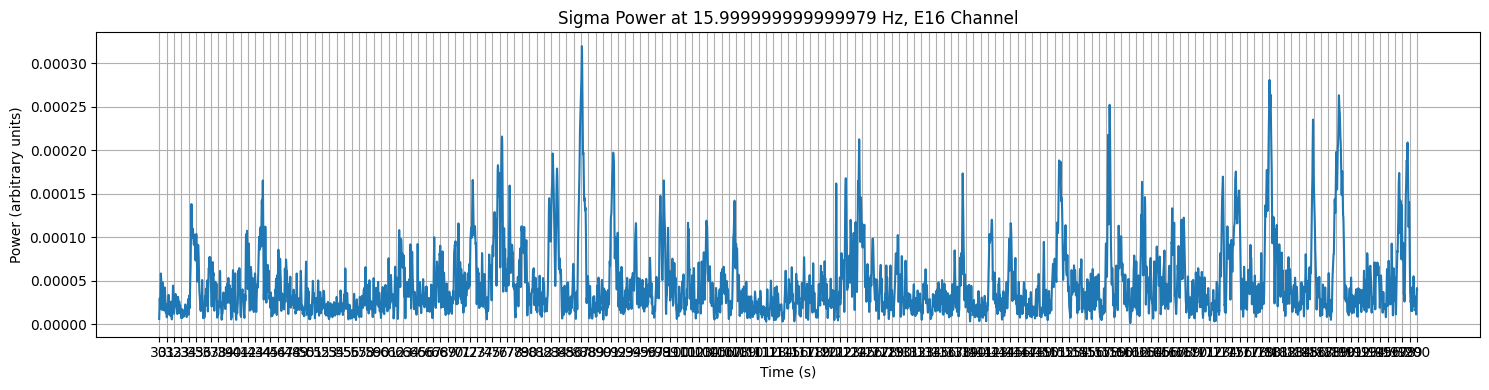

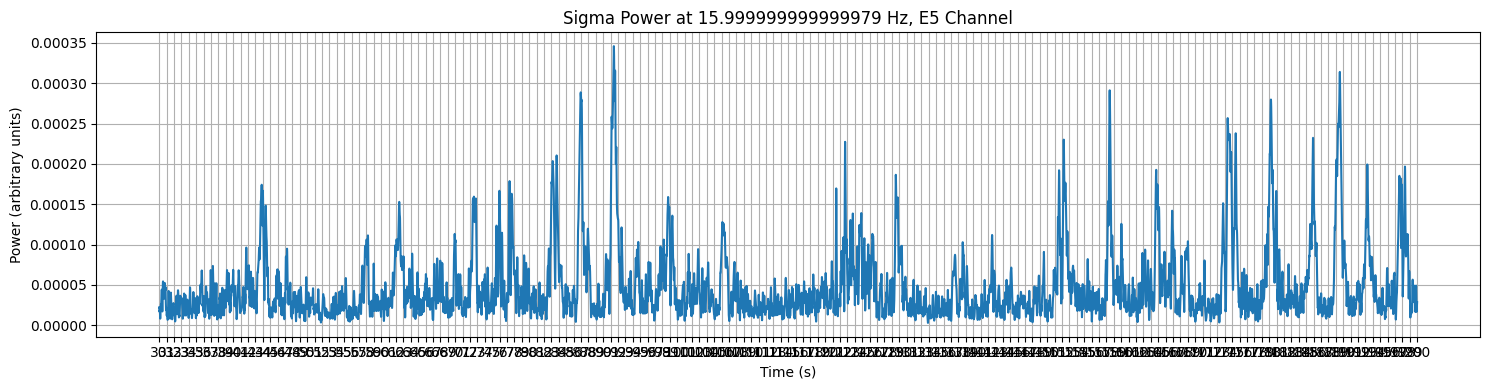

In [136]:
sigma_avg_freq = sigma_power_all.mean(axis=0)  # shape: (n_channels, n_times)
df_sigma_power = pd.DataFrame(sigma_avg_freq.T, columns=channel_names)
df_sigma_power.insert(0, 'Time (s)', times)
for channel in channel_names:
# channel_to_plot = 'VREF'
    start = 30
    end = 200
    df_window = df_sigma_power[(df_sigma_power['Time (s)'] >= start) & 
                               (df_sigma_power['Time (s)'] <= end)]

    plt.figure(figsize=(15, 4))
    plt.plot(df_window['Time (s)'], df_window[channel])
    plt.title(f'Sigma Power at {wavelet_freq} Hz, {channel} Channel')
    plt.xlabel('Time (s)')
    plt.ylabel('Power (arbitrary units)')
    plt.xticks(np.arange(start, end+1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

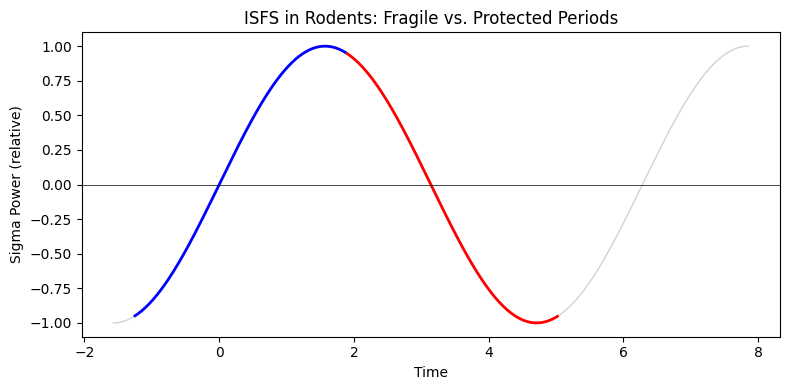

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Time vector
x = np.linspace(-0.5 * np.pi, 2.5 * np.pi, 500)
y = np.sin(x)

# Create masks for up-phase (protected) and down-phase (fragile)
fragile_mask = (x > 0.6 * np.pi) & (x < 1.6 * np.pi)  # down-phase and trough
protected_mask = (x < 0.6 * np.pi) & (x > -0.4 * np.pi)  # up-phase and peak

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x, y, color='lightgray', linewidth=1)  # base wave

# Overlay colored segments
plt.plot(x[fragile_mask], y[fragile_mask], color='red', linewidth=2, label='Fragile Period')
plt.plot(x[protected_mask], y[protected_mask], color='blue', linewidth=2, label='Protected Period')

# Add axis and labels
plt.axhline(0, color='black', linewidth=0.5)
plt.title("ISFS in Rodents: Fragile vs. Protected Periods")
plt.xlabel("Time")
plt.ylabel("Sigma Power (relative)")
# plt.legend()
plt.tight_layout()
# plt.grid(True)
plt.show()


### Sigma power over full bout

In [ ]:
orig_data = target_raw.get_data()[0] # V
bandpass_data, times = spindle_bandpass.get_data(return_times=True)
bandpass_data = bandpass_data[0] # V
analytic_signal = hilbert(bandpass_data)
amplitude_envelope = np.abs(analytic_signal)
amplitude_envelope = amplitude_envelope - np.mean(amplitude_envelope)

In [216]:
# Scales sanity check
print(f"Orig: min {orig_data.min():.6f} V, max {orig_data.max():.6f} V")
print(f"Sigma: min {bandpass_data.min():.6f} V, max {bandpass_data.max():.6f} V")
print(f"Envelope: min {amplitude_envelope.min():.6f} V, max {amplitude_envelope.max():.6f} V")

Orig: min -0.000087 V, max 0.000084 V
Sigma: min -0.000026 V, max 0.000026 V
Envelope: min -0.000003 V, max 0.000023 V


In [14]:
# create a raw with the original channel + sigma power + sigma envelope
sfreq = target_raw.info['sfreq']
combined_data = np.vstack([orig_data, bandpass_data, amplitude_envelope])

ch_names = [target_channel, f'{target_channel}_sigma', f'{target_channel}_sigma_env']
ch_types = ['eeg', 'ecg', 'misc']  # 'misc' so MNE doesn’t apply EEG-specific scaling
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw_combined = mne.io.RawArray(combined_data, info)
_ = raw_combined.set_meas_date(target_raw.info['meas_date'])

In [15]:
offset_sec = target_raw.first_samp / sfreq
annotations = target_raw.annotations.copy()
annotations.onset = annotations.onset - offset_sec
_ = raw_combined.set_annotations(annotations)

In [19]:
scalings = {
    'eeg': 1e-4,   # Original EEG ~100 µV scale
    'ecg': 5e-5,   # Sigma band ~50 µV scale
    'misc': 1e-5   # Envelope ~10 µV scale
}
raw_combined.plot(duration=45, scalings=scalings)

### FFT over the sigma envelope 

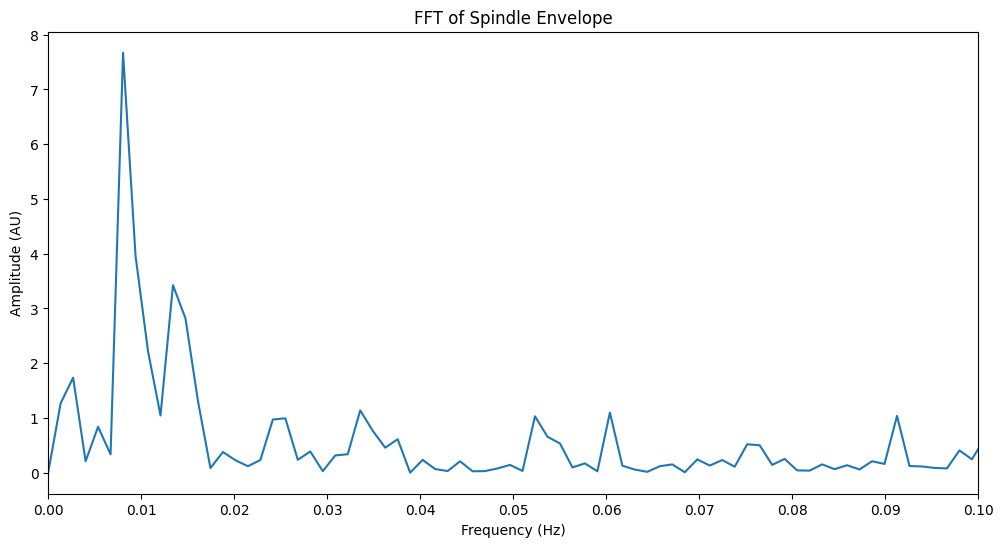

In [281]:
n_samples = amplitude_envelope.shape[0]
freqs = np.fft.rfftfreq(n_samples, d=1/sfreq)
fft_values = np.fft.rfft(amplitude_envelope)
fft_power = np.abs(fft_values) ** 2
fft_power *= 1e6        # to avoid really small numbers. TODO: does that make sense?
fft_power = fft_power / (n_samples / sfreq) # normalized by length

plt.figure(figsize=(12, 6))
plt.plot(freqs, fft_power)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (AU)')
plt.title('FFT of Spindle Envelope')
start, end = 0, 0.1
plt.xlim(start, end)
plt.xticks(np.linspace(start, end, 11))
plt.show()

In [282]:
min_freq, max_freq = 0, 0.1
mask = (freqs >= min_freq) & (freqs <= max_freq)
x = freqs[mask]
y = fft_power[mask]

def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Params order: amplitude peak, center, STD
# Initial guess: max(y), mean freq, some small value
p0 = [np.max(y), x[np.argmax(y)], 0.01]
fitted_params, _ = curve_fit(gaussian, x, y, p0=p0)
peak, mu, sigma = fitted_params


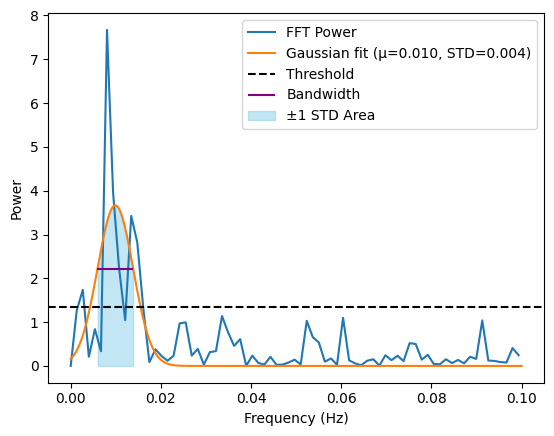

In [283]:
x_fit = np.linspace(min_freq, max_freq, 500)
y_fit = gaussian(x_fit, *fitted_params)
x1 = mu - sigma
x2 = mu + sigma
mask = (x_fit >= x1) & (x_fit <= x2)
bandwidth_height = gaussian(x1, *fitted_params)
area = simpson(x=x_fit[mask], y=y_fit[mask])
threshold = 1.5 * np.std(y_fit) # what should be the threshold? 

plt.plot(x, y, label='FFT Power')
plt.plot(x_fit, y_fit, label=f'Gaussian fit (μ={mu:.3f}, STD={sigma:.3f})')
plt.axhline(threshold, color='black', linestyle='--', label=f'Threshold')
plt.hlines(bandwidth_height, x1, x2, colors="purple", label="Bandwidth")
plt.fill_between(x_fit[mask], y_fit[mask], color='skyblue', alpha=0.5, label='±1 STD Area')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()
plt.show()

In [349]:
if peak > threshold:
    print("ISFS detected! The parameters:")
    print(f"\tpeak: {peak:.3f}\n\tbandwidth: {2 * sigma:.3f}\n\tAUC: {area:.3f}\n\tcenter: {mu:.3f}")

ISFS detected! The parameters:
	peak: 3.665
	bandwidth: 0.008
	AUC: 0.025
	center: 0.010


### Temporal Analysis of Sigma Power

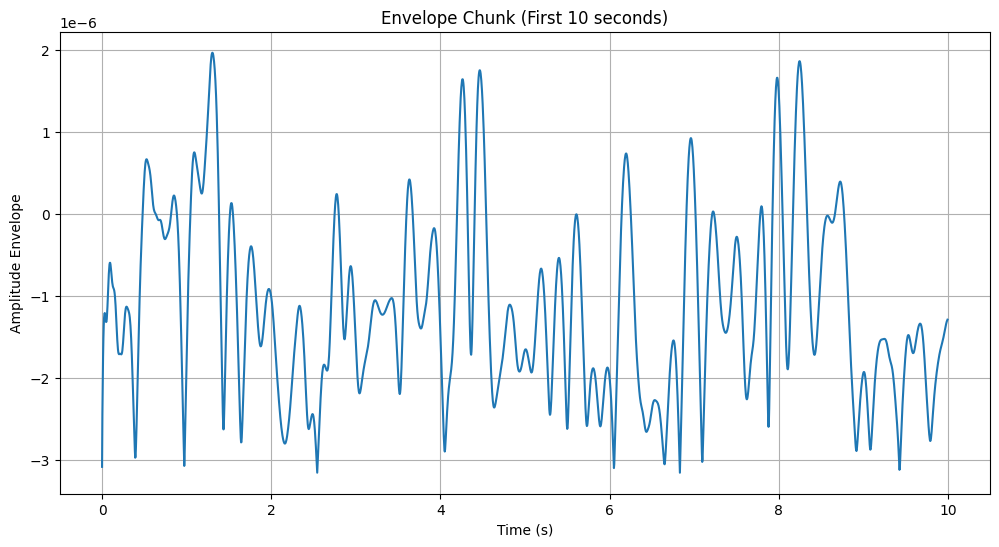

In [34]:
chunk_duration = 10
start_sample = 0
end_sample = int(chunk_duration * sfreq)

chunk = amplitude_envelope[start_sample:end_sample]
time = np.arange(start_sample, end_sample) / sfreq

plt.figure(figsize=(12, 6))
plt.plot(time, chunk)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude Envelope')
plt.title(f'Envelope Chunk (First {chunk_duration} seconds)')
plt.grid(True)
plt.show()

In [41]:
import numpy as np
from scipy.signal.windows import tukey
from scipy.signal import butter, filtfilt

def compute_isfs_phase_bins(amplitude_envelope: np.ndarray, sfreq: float):
    """
    Parameters
    ----------
    amplitude_envelope : np.ndarray
        1D array of your sigma-power envelope (already demeaned).
    sfreq : float
        Sampling rate (Hz).

    Returns
    -------
    slow_env_z : np.ndarray
        Zero-mean, unit-variance infraslow envelope (<0.04 Hz).
    phase_bins : np.ndarray
        Integer array (same length) marking each sample's phase bin 1-8, or -1 if not in a full ISFS cycle.
    cycles : List[Tuple[int,int]]
        List of (start_sample, end_sample) for each detected 25-100 s ISFS cycle.
    """
    # 1) taper edges with a Tukey window to avoid filter ringing
    taper_win = tukey(len(amplitude_envelope), alpha=0.1)
    env_tapered = amplitude_envelope * taper_win

    # 2) zero‐phase low‐pass filter at 0.04 Hz (Butterworth, 5th order)
    nyq = sfreq / 2.0
    b, a = butter(5, 0.04 / nyq, btype='low')
    slow_env = filtfilt(b, a, env_tapered)

    # 3) standardize to zero mean & unit variance
    slow_env_z = (slow_env - np.mean(slow_env)) / np.std(slow_env)

    # 4) find zero‐crossings
    signs = np.sign(slow_env_z)
    neg_zc = np.where((signs[:-1] > 0) & (signs[1:] < 0))[0] + 1  # negative‐going
    pos_zc = np.where((signs[:-1] < 0) & (signs[1:] > 0))[0] + 1  # positive‐going

    # 5) detect ISFS cycles: negative zero crossings 25–100 s apart
    cycles = []
    for i in range(len(neg_zc) - 1):
        t0, t1 = neg_zc[i], neg_zc[i + 1]
        dt = (t1 - t0) / sfreq
        if 25 <= dt <= 100:
            cycles.append((t0, t1))

    # 6) assign each sample to a phase bin (1–8) or –1
    phase_bins = np.full(len(slow_env_z), -1, dtype=int)
    for start, end in cycles:
        # trough = min point in cycle
        trough_idx = start + np.argmin(slow_env_z[start:end])
        # peak = max point after trough
        peak_idx   = trough_idx + np.argmax(slow_env_z[trough_idx:end])
        # midpoint = first positive zero crossing between trough and peak
        mids = pos_zc[(pos_zc > trough_idx) & (pos_zc < peak_idx)]
        if mids.size == 0:
            continue
        midpoint_idx = mids[0]

        # boundaries splitting the cycle into 8 equal‐phase segments
        e1 = (start     + trough_idx) // 2
        e2 = (trough_idx + midpoint_idx) // 2
        e3 = (midpoint_idx + peak_idx) // 2
        e4 = (peak_idx   + end) // 2

        # fill bins 1–8
        phase_bins[start:  e1] = 1
        phase_bins[e1:     trough_idx] = 2
        phase_bins[trough_idx: e2] = 3
        phase_bins[e2:     midpoint_idx] = 4
        phase_bins[midpoint_idx: e3] = 5
        phase_bins[e3:     peak_idx] = 6
        phase_bins[peak_idx:   e4] = 7
        phase_bins[e4:     end] = 8

    return slow_env_z, phase_bins, cycles

slow_env_z, phase_bins, cycles = compute_isfs_phase_bins(amplitude_envelope, sfreq)


In [73]:
sigma_env_raw = raw_combined.copy().pick_channels([f"{target_channel}_sigma_env"])
sigma_env_raw.filter(l_freq=None, h_freq=0.3, picks="all")
filtered_env = sigma_env_raw.get_data()[0]
sigma_data_z = (filtered_env - np.mean(filtered_env)) / np.std(filtered_env)
new_info = mne.create_info(ch_names=[f"{target_channel}_sigma_env_filtered", f"{target_channel}_sigma_z"], sfreq=sfreq, ch_types=["misc", "stim"])
filtered_raw = mne.io.RawArray(np.vstack([filtered_env, sigma_data_z]), new_info)

In [63]:
_ = raw_combined.add_channels([filtered_raw])

In [67]:
scal = {
    'eeg': 1e-4,   # Original EEG ~100 µV scale
    'ecg': 5e-5,   # Sigma band ~50 µV scale
    'misc': 1e-5 ,  # Envelope ~10 µV scale
    'stim': 1
}
raw_combined.plot(duration=100, scalings=scal)

In [65]:
peaks, _ = find_peaks(sigma_data_z, height=0)
troughs, _ = find_peaks(-sigma_data_z, height=0)
zero_crossings = np.where(np.diff(np.sign(sigma_data_z)))[0]
neg_zero_cross = zero_crossings[sigma_data_z[zero_crossings] > 0]       # (+ to -)
pos_zero_cross = zero_crossings[sigma_data_z[zero_crossings] < 0]       # (- to +)

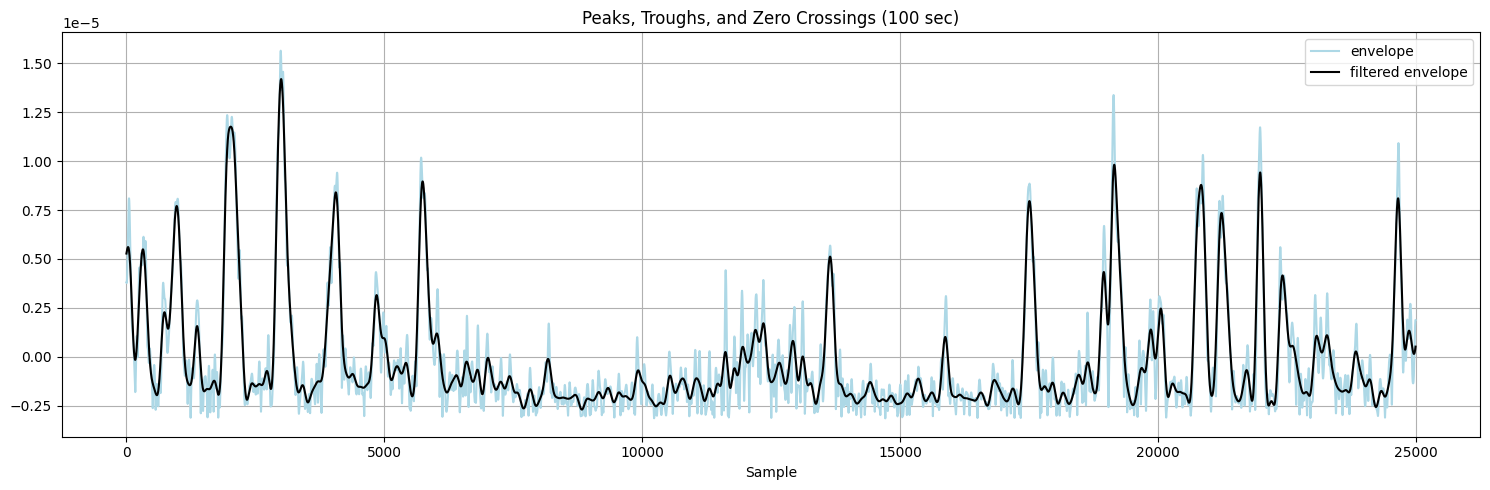

In [74]:
start_time = 75
end_time = 175
X0 = int(start_time * sfreq)
X1 = int(end_time * sfreq)
data_segment = sigma_data_z[X0:X1]
peaks_segment = peaks[(peaks >= X0) & (peaks < X1)] - X0
troughs_segment = troughs[(troughs >= X0) & (troughs < X1)] - X0
neg_zc_segment = neg_zero_cross[(neg_zero_cross >= X0) & (neg_zero_cross < X1)] - X0
pos_zc_segment = pos_zero_cross[(pos_zero_cross >= X0) & (pos_zero_cross < X1)] - X0

plt.figure(figsize=(15, 5))
plt.plot(amplitude_envelope[X0:X1], label='envelope', color='lightblue')
plt.plot(filtered_env[X0:X1], label='filtered envelope', color='k')
# plt.plot(slow_env_z[X0:X1], label='Z-scored slow', color='pink')
# plt.plot(peaks_segment, data_segment[peaks_segment], "ro", label="Peaks")
# plt.plot(troughs_segment, data_segment[troughs_segment], "bo", label="Troughs")
# plt.plot(neg_zc_segment, data_segment[neg_zc_segment], "gx", label="Negative zero crossings", color="orange")
# plt.plot(pos_zc_segment, data_segment[pos_zc_segment], "gx", label="Positive zero crossings", color="green")
plt.legend()
plt.title(f"Peaks, Troughs, and Zero Crossings ({end_time - start_time} sec)")
plt.xlabel("Sample")
# plt.ylim((-2, 4))
plt.grid(True)
plt.tight_layout()
plt.show()